In [7]:
import os 
import sys 
sys.path.append('..')
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## 画出训练曲线

In [52]:
# df = pd.read_csv('../result/LSTM_result_file.csv')
# df = pd.read_csv('../result/ANN_nD.csv')
# df = pd.read_csv('../result/one_LSTM_result_file.csv')
# df = pd.read_csv('../result/LSTM_1D.csv')
df = pd.read_csv('../result/EDLSTM_nD.csv')
# df = pd.read_csv('../result/EDLSTM_1D_tf.csv')

In [53]:
df.tail(3)

,start_time,model_name,model_pkl_path,device,learning_rate,batch size,encoder_sequence_length,decoder_sequence_length,best_train_l1_loss,best_train_mse_loss,best_valid_l1_loss,best_valid_mse_loss,epoch_for_best_valid_loss,train_mse_curve,valid_mse_curve
17,2019-11-04 15:00:50.968529,EDLSTM_nD,../rnn_model/saved_pkl_model/EDLSTM_nD.pkl,cuda:0,0.00003,1.0,40.0,4.0,1000.000000,1000.000000,1000.000000,1000.000000,0.0,"[1, 2, 3]","[1, 2, 3]"
18,2019-11-04 17:19:05.459737,EDLSTM_nD,../rnn_model/saved_pkl_model/EDLSTM_nD.pkl,cuda:0,0.00003,32.0,40.0,4.0,0.046246,0.003541,0.061117,0.007377,100.0,"[0.07746623757842966, 0.02425477651782243, 0.0...","[0.036683736238902545, 0.02882250730181113, 0...."
19,2019-11-05 11:09:22.734392,EDLSTM_nD,../rnn_model/saved_pkl_model/EDLSTM_nD.pkl,cuda:0,0.00001,32.0,40.0,4.0,0.045690,0.003566,0.072444,0.010042,399.0,"[0.13445528359425687, 0.0603620332901924, 0.04...","[0.07002067639875938, 0.05554477503756061, 0.0..."


In [54]:
train_curve = df['train_mse_curve'].iloc[-1]
valid_curve = df['valid_mse_curve'].iloc[-1]
train_curve = list(map(float, train_curve[1: -1].split(',')))
valid_curve = list(map(float, valid_curve[1: -1].split(',')))

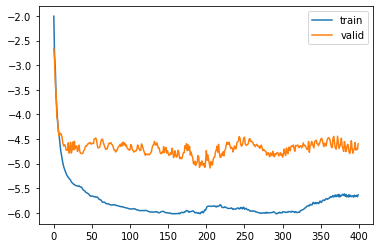

In [55]:
plt.figure(facecolor='w')
plt.plot(np.log(train_curve))
plt.plot(np.log(valid_curve))
plt.legend(['train', 'valid'])
plt.show()

## 探究模型效果

In [56]:
import sys
sys.path.append('..')
import torch
from datetime import datetime
from torch.utils.data import DataLoader
from src.py_dataset import GpuDataset
from matplotlib import pyplot as plt

In [58]:
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/ANN_nD.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/one_LSTM.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/LSTM_1D.pkl', map_location='cpu')
model = torch.load('../rnn_model/saved_pkl_model/EDLSTM_nD.pkl', map_location='cpu')
# model = torch.load('../rnn_model/saved_pkl_model/EDLSTM_1D_tf.pkl', map_location='cpu')


dataset_path = '../Dataset/3bs_8q_4p_dataset_washed.csv'
dataset = GpuDataset('valid', dataset_path, 40, 4)
dataloader = DataLoader(dataset,
                        batch_size=2,
                        shuffle=False)
data = dataset.data

dataset prepared !


In [59]:
model

EDLSTM_nD(
  (encoder): LSTM(37, 64, num_layers=2, batch_first=True)
  (decoder_cell): LSTMCell(20, 64)
  (out_layer): Linear(in_features=64, out_features=1, bias=True)
  (embed_hour): Embedding(24, 5)
  (embed_weekday): Embedding(8, 3)
  (embed_month): Embedding(13, 4)
  (embed_weekofyear): Embedding(54, 7)
  (Tanh): Tanh()
)

In [60]:
data['out_pressure'].describe()

count    4493.000000
mean        0.402748
std         0.265059
min         0.000000
25%         0.119617
50%         0.468900
75%         0.612440
max         1.000000
Name: out_pressure, dtype: float64

In [61]:
output_list = []
for i, (input_p, input_time, label_p, decoder_time) in enumerate(dataloader):
#     print(\r, i, end='')
    outputs_p = model(input_p, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
#     outputs_p = model(input_p, input_time)
    output_list += [outputs_p[0, -1].detach().numpy(),
                    outputs_p[1, -1].detach().numpy()]
    if i > 2100:
        break

# # 多步预测
# output_list = []
# output_list_30min = []
# label_list = []
# for i, (input_p_q, input_time, label_p, decoder_time) in enumerate(dataloader):
#     label_list += [label_p[:,43]]
#     for j in range(0, 4):
#         outputs_p = model(input_p_q, input_time, label_p, decoder_time)  # torch.Size([64, 10, 9])
#         label_p[:, 0:39] = label_p[:,1:40]
#         label_p[:, 39] = outputs_p.squeeze(2)[:,-1]
#         if j == 0:
#             output_list_30min += [outputs_p[0, -1, :].detach().numpy()]    
#         if j == 3:
#             output_list += [outputs_p[0, -1, :].detach().numpy()]
# #     if i > 1500:
# #         break

In [62]:
data['out_pressure_pred'] = 0
data['out_pressure_pred'].iloc[:len(output_list)] = output_list
data['out_pressure_pred'] = data['out_pressure_pred'].copy().shift(40+4)
# data['datetime'] = data['datetime'].apply(str_to_datetime)

G:\Anaconda\envs\pytorch_env\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [63]:
len(output_list)

4204

In [64]:
data.shape

(4493, 28)

In [65]:
outputs_p.shape

torch.Size([2, 4, 1])

../result/figures/EDLSTM_nD.png
fig_rewrited !


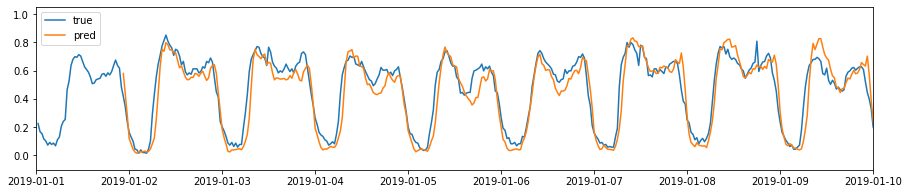

In [66]:
plt.figure(figsize=(15,3), facecolor='w')
plt.plot(data['datetime'], data['out_pressure'])
plt.plot(data['datetime'], data['out_pressure_pred'])
plt.xlim([datetime(2019,1,1), datetime(2019, 1, 10)])
fig_path = '../result/figures/' + model.model_name + '.png'
print(fig_path)
if not os.path.exists(fig_path):
    plt.savefig(fig_path, format='png',dpi=1000)
    print('fig_svaed !')
else:
    plt.savefig(fig_path, format='png',dpi=1000)
    print('fig_rewrited !')
plt.legend(['true', 'pred'])
plt.show()

In [67]:
from sklearn import metrics
import numpy as np
from sklearn import preprocessing
def eval_metrics(y_true, y_pred):
    metrics_dict = dict()
    metrics_dict['MAE'] = metrics.mean_absolute_error(y_true, y_pred)
    metrics_dict['MSE'] = metrics.mean_squared_error(y_true, y_pred)
    metrics_dict['MAPE'] = np.mean(np.true_divide(np.abs(y_true-y_pred), y_true))
    return metrics_dict
y_pred = data['out_pressure_pred'].iloc[48:].values
y_true = data['out_pressure'].iloc[48:].values 
eval_dict = eval_metrics(y_true, y_pred)

G:\Anaconda\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [68]:
eval_dict

{'MAE': 0.10192420014506152, 'MSE': 0.0295234483890389, 'MAPE': inf}